In [1]:
import os
from itertools import product
from joblib import Parallel, delayed

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec

import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_ttests, linear_regression
from statsmodels.regression.mixed_linear_model import MixedLM
from numba import njit

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u


ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
plt.rcParams['pdf.fonttype']=42

%matplotlib inline

%load_ext autoreload
%autoreload 2

rng = np.random.default_rng()

In [2]:
figdir = "/mnt/BigDisk/YMazeResults/neural/across_day_decoding"
os.makedirs(figdir,exist_ok=True)

In [3]:
gamma = lambda x,kappa:  1/sp.special.gamma(kappa)* np.exp(-x)*np.power(x,kappa-1)
poiss = lambda k,lam:  1/sp.special.gamma(k)* np.exp(-lam)*np.power(lam,k)

def logsumexp(x,axis=-1):
    c = x.max(axis = axis, keepdims=True) + 1E-5
    return c + np.log(np.sum(np.exp(x - c ),axis=axis, keepdims=True))


In [4]:
def crossval(sess, n_cells = -1, poisson = True, nov = False):
    
    # assuming uniform prior over bins
    if nov:
        trial_mask = sess.trial_info['LR']==sess.novel_arm
    else:
        trial_mask = sess.trial_info['LR']==-1*sess.novel_arm
        
    trial_mat = sess.trial_matrices['spks'][trial_mask,:,:]*10
    trial_mat -= np.amin(trial_mat,axis=-1,keepdims=True)
    trial_mat += 1E-3

    # select cells
    if n_cells ==-1:
#         print('all_cells')
        pass
    else:
        rng = np.random.default_rng()
        trial_mat = trial_mat[:,:,rng.permutation(trial_mat.shape[-1])[:n_cells]]
    
    posterior = np.zeros([trial_mat.shape[0], trial_mat.shape[1], trial_mat.shape[1]])
    for trial in range(trial_mat.shape[0]):
        
        mask = np.zeros((trial_mat.shape[0],))<1
        mask[trial] = False
        
        trial_mat_mean = np.nanmean(trial_mat[mask,:,:],axis=0)
        
        y = np.copy(trial_mat[trial,:,:])
        y[np.isnan(y)]=1E-3
        log_likelihood = 0
        for cell in range(trial_mat.shape[-1]):
            if poiss:
                log_likelihood += np.log(poiss(y[:,cell:cell+1], trial_mat_mean[:,cell:cell+1].T)+1E-3)
            else:
                log_likelihood += np.log(gamma(y[:,cell:cell+1], trial_mat_mean[:,cell:cell+1].T)+1E-3)
        
        posterior[trial,:,:] = np.exp(log_likelihood - logsumexp(log_likelihood))
        

    
    return posterior

def calc_posterior(trial_mat, avg_mat):
    
    posterior = np.zeros((trial_mat.shape[0], trial_mat.shape[1], trial_mat.shape[1]))
    for trial in range(trial_mat.shape[0]):
        
        mask = np.zeros((trial_mat.shape[0],))<1
        mask[trial] = False
        
        trial_mat_mean = np.nanmean(trial_mat[mask,:,:],axis=0)
        
        y = np.copy(trial_mat[trial,:,:])
        y[np.isnan(y)]=1E-3
        log_likelihood = 0
        for cell in range(trial_mat.shape[-1]):
            if poiss:
                log_likelihood += np.log(poiss(y[:,cell:cell+1], avg_mat[:,cell:cell+1].T)+1E-3)
            else:
                log_likelihood += np.log(gamma(y[:,cell:cell+1], avg_mat[:,cell:cell+1].T)+1E-3)
        
        posterior[trial,:,:] = np.exp(log_likelihood - logsumexp(log_likelihood))
    return posterior
        


def test(_y, trial_mat_mean, poisson=False):
    log_likelihood = 0
    for cell in range(trial_mat_mean.shape[-1]):
        yc, tmm = _y[:,cell], trial_mat_mean[:,cell]
        if poisson:
            log_likelihood += np.log(poiss(yc[:,np.newaxis], tmm[np.newaxis,:])+1E-3)
        else:
            log_likelihood += np.log(gamma(yc[:,np.newaxis], tmm[np.newaxis,:])+1E-3)
    return np.exp(log_likelihood - logsumexp(log_likelihood))

In [5]:
ctrl_post = []
n_cells = 500
rng = np.random.default_rng()
        
for m, mouse in enumerate(ctrl_mice):
    sess = u.load_single_day(mouse,0)
    
    novel_mask = sess.trial_info['LR']==sess.novel_arm
    trial_mat = sess.trial_matrices['spks'][~novel_mask,:,:]
    trial_mat[np.isnan(trial_mat)] = 1E-5
    trial_mat = trial_mat[:,:,rng.permutation(trial_mat.shape[-1])[:n_cells]]
    test_mat = trial_mat[:20,:,:]
    avg_mat = trial_mat[-20:,:,:].mean(axis=0)

    ctrl_post.append(calc_posterior(test_mat, avg_mat).mean(axis=0))

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}


In [6]:
ko_post = []
for m, mouse in enumerate(ko_mice):
    sess = u.load_single_day(mouse,0)
    
    novel_mask = sess.trial_info['LR']==sess.novel_arm
    trial_mat = sess.trial_matrices['spks'][~novel_mask,:,:]
    trial_mat[np.isnan(trial_mat)] = 1E-5
    trial_mat = trial_mat[:,:,rng.permutation(trial_mat.shape[-1])[:n_cells]]
    test_mat = trial_mat[:20,:,:]
    avg_mat = trial_mat[-20:,:,:].mean(axis=0)

    ko_post.append(calc_posterior(test_mat, avg_mat).mean(axis=0))

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:97: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 0}


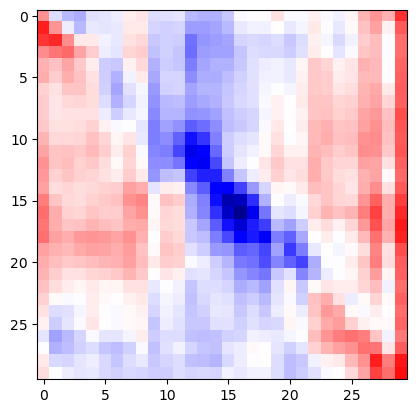

In [7]:
fig,ax = plt.subplots()
ax.imshow(np.array(ko_post).mean(axis=0)-np.array(ctrl_post).mean(axis=0), cmap='seismic',
         vmin=-.03, vmax=.03)


In [5]:
def train_oneday_test_multiday(_concat_sess, train_day, test_days, n_cells = -1, poisson = True):
    # assuming uniform prior over bins
    
    #ensure common rois
    train_mask = (_concat_sess.trial_info['sess_num']==train_day)
    fam_train = (_concat_sess.trial_info['sess_num']==train_day)*(_concat_sess.trial_info['LR']==-1*_concat_sess.novel_arm)
    nov_train = (_concat_sess.trial_info['sess_num']==train_day)*(_concat_sess.trial_info['LR']==_concat_sess.novel_arm)
    
    trial_mat = np.copy(_concat_sess.trial_matrices['spks'])*10
    trial_mat -= np.amin(trial_mat,axis=-1,keepdims=True)
    trial_mat += 1E-3

    
    # select cells
    if n_cells ==-1:
        pass
    else:
        rng = np.random.default_rng()
        trial_mat = trial_mat[:,:,rng.permutation(trial_mat.shape[-1])[:n_cells]]
    
    fam_mean = np.nanmean(trial_mat[fam_train,:,:],axis=0)
    nov_mean = np.nanmean(trial_mat[nov_train,:,:],axis=0)
    
    fam_train_post = np.zeros([trial_mat.shape[0], trial_mat.shape[1], trial_mat.shape[1]])*np.nan
    nov_train_post = np.zeros([trial_mat.shape[0], trial_mat.shape[1], trial_mat.shape[1]])*np.nan
    for trial in range(trial_mat.shape[0]):
        
        if not train_mask[trial]:
            fam_train_post[trial, :, :] = test(np.copy(trial_mat[trial, :, :]), fam_mean, poisson=poisson)
            nov_train_post[trial, :, :] = test(np.copy(trial_mat[trial, :, :]), nov_mean, poisson=poisson)
    return fam_train_post, nov_train_post

In [6]:
n_cells = 1000
def run_mice_multiday(mice, days = [i for i in range(6)]):
    results = {}
    for mouse in mice:
        print(mouse)
        
        concat_sess = u.single_mouse_concat_sessions(mouse,date_inds=days)
        fam_train, nov_train = [],[]
        for train_ind in list(days):
            print('train ind', train_ind)
            _fam_train, _nov_train = train_oneday_test_multiday(concat_sess, days[train_ind],[ind for ind in days if ind != train_ind], n_cells = n_cells, poisson = True)
            fam_train.append(_fam_train)
            nov_train.append(_nov_train)
        results[mouse] = {'fam_train': np.array(fam_train), 
                          'nov_train': np.array(nov_train), 
                          'sess_num': concat_sess.trial_info['sess_num'], 
                          'novel_trials': concat_sess.trial_info['LR']==concat_sess.novel_arm,
                          'fam_trials': concat_sess.trial_info['LR']==-1*concat_sess.novel_arm}
    return results
            


ko_multiday_results = run_mice_multiday(stx.ymaze_sess_deets.KO_sessions.keys())
ctrl_multiday_results = run_mice_multiday(stx.ymaze_sess_deets.CTRL_sessions.keys())


4467975.1


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:97: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


28_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


29_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel
02_10_2020 YMaze_LNovel
03_10_2020 YMaze_LNovel
train ind 0
train ind 1
train ind 2
train ind 3
train ind 4
train ind 5
4467975.2


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:97: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


28_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


29_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


30_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


01_10_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


02_10_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


03_10_2020 YMaze_LNovel
train ind 0
train ind 1
train ind 2
train ind 3
train ind 4
train ind 5
4467975.3


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:97: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


28_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


29_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel
02_10_2020 YMaze_LNovel
03_10_2020 YMaze_LNovel
train ind 0
train ind 1
train ind 2
train ind 3
train ind 4
train ind 5
4467975.4
28_09_2020 YMaze_LNovel
29_09_2020 YMaze_LNovel
30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel
02_10_2020 YMaze_LNovel
03_10_2020 YMaze_LNovel
train ind 0
train ind 1
train ind 2
train ind 3
train ind 4
train ind 5
4467975.5
28_09_2020 YMaze_LNovel
29_09_2020 YMaze_LNovel
30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel
02_10_2020 YMaze_LNovel
03_10_2020 YMaze_LNovel
train ind 0
train ind 1
train ind 2
train ind 3
train ind 4
train ind 5
Cre7
18_10_2021 YMaze_LNovel
19_10_2021 YMaze_LNovel
20_10_2021 YMaze_LNovel
21_10_2021 YMaze_LNovel
22_10_2021 YMaze_LNovel
23_10_2021 YMaze_LNovel
train ind 0
train ind 1
train ind 2
train ind 3
train ind 4
train ind 5
Cre9
18_10_2021 YMaze_LNovel
19_10_2021 YMaze_LNovel
20_10_2021 YMaze_LNovel
21_10_2021 YMaze_LNovel
23_10_2021 YMaze_LNovel
23_10_2021 YMaze_LNovel
train ind 

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:97: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


05_12_2020 YMaze_LNovel
train ind 0
train ind 1
train ind 2
train ind 3
train ind 4
train ind 5
mCherry6
14_10_2021 YMaze_LNovel
15_10_2021 YMaze_LNovel
16_10_2021 YMaze_LNovel
17_10_2021 YMaze_LNovel
18_10_2021 YMaze_LNovel
19_10_2021 YMaze_LNovel
train ind 0
train ind 1
train ind 2
train ind 3
train ind 4
train ind 5
mCherry7
14_10_2021 YMaze_LNovel
15_10_2021 YMaze_LNovel
16_10_2021 YMaze_LNovel
17_10_2021 YMaze_LNovel
18_10_2021 YMaze_LNovel
19_10_2021 YMaze_LNovel
train ind 0
train ind 1
train ind 2
train ind 3
train ind 4
train ind 5
mCherry8
14_10_2021 YMaze_LNovel
15_10_2021 YMaze_LNovel
16_10_2021 YMaze_LNovel
17_10_2021 YMaze_LNovel
18_10_2021 YMaze_LNovel
20_10_2021 YMaze_LNovel
train ind 0
train ind 1
train ind 2
train ind 3
train ind 4
train ind 5
mCherry9
15_10_2021 YMaze_LNovel
16_10_2021 YMaze_LNovel
17_10_2021 YMaze_LNovel
19_10_2021 YMaze_LNovel
20_10_2021 YMaze_LNovel
21_10_2021 YMaze_LNovel
train ind 0
train ind 1
train ind 2
train ind 3
train ind 4
train ind 5


In [7]:
# fig,ax = plt.subplots(6,1, figsize=[5,25])


ctrl_shift = np.zeros((len(ctrl_mice),6,6))*np.nan
for m, mouse in enumerate(ctrl_mice):
    res = ctrl_multiday_results[mouse]
    for test_day in range(6):
        test_trials = (res['sess_num']==test_day)*(res['novel_trials']>0)
        for train_day in range(6):
            if (train_day >test_day):
                shift = (np.argmax(res['nov_train'][train_day][test_trials,:,:],axis=-1)-np.arange(30)[np.newaxis,:]).mean(axis=-1)
                ctrl_shift[m, test_day,train_day] = np.mean(shift)
            # ax[day].plot(shift, color='black')
        
ko_shift = np.zeros((len(ko_mice),6,6))*np.nan
for m, mouse in enumerate(ko_mice):
    res = ko_multiday_results[mouse]
    for test_day in range(6):
        test_trials = (res['sess_num']==test_day)*(res['novel_trials']>0)
        for train_day in range(6):
            if (train_day > test_day):
                shift = (np.argmax(res['nov_train'][train_day][test_trials,:,:],axis=-1)-np.arange(30)[np.newaxis,:]).mean(axis=-1)
                ko_shift[m, test_day, train_day] = np.mean(shift)
            # ax[day].plot(shift, color='red')

In [8]:
# Try excluding reward zone in analy

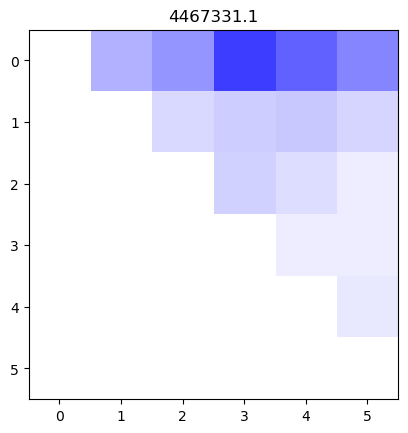

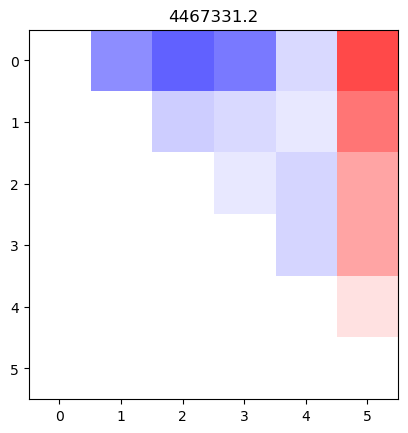

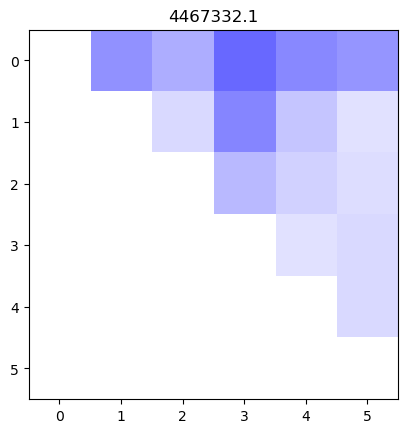

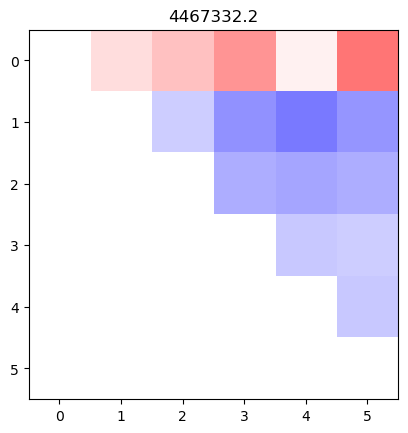

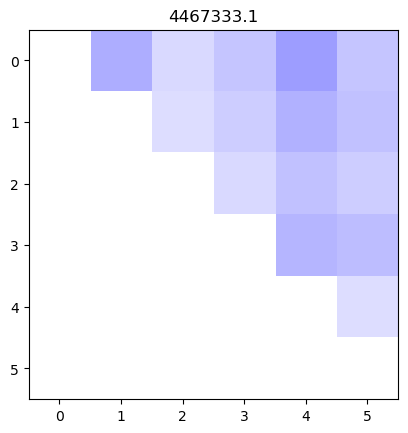

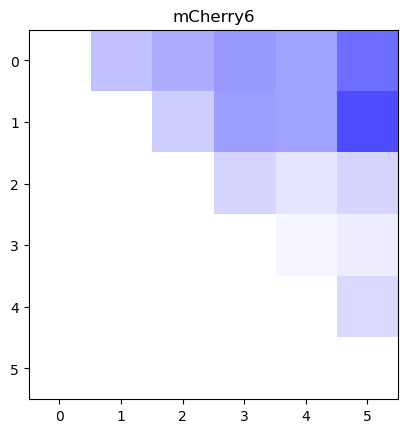

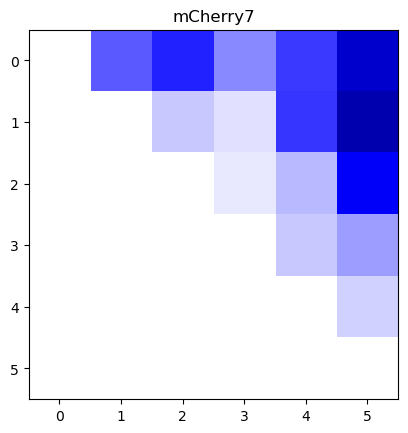

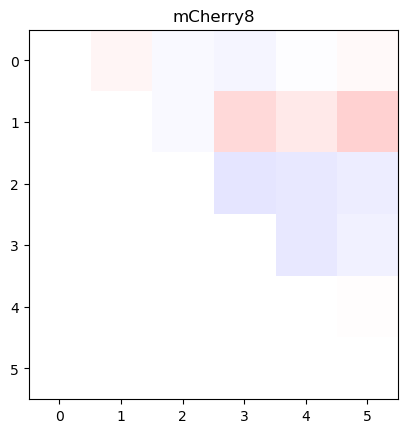

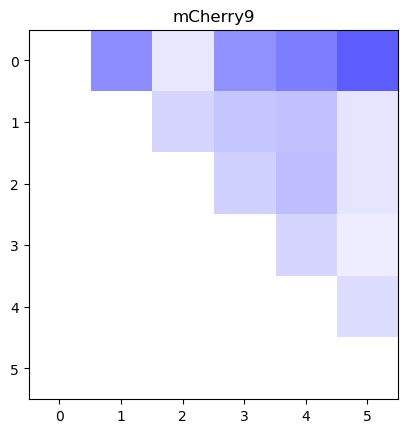

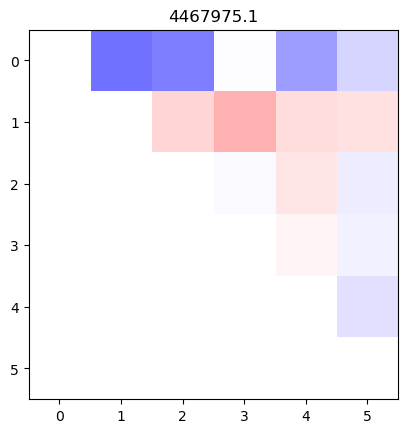

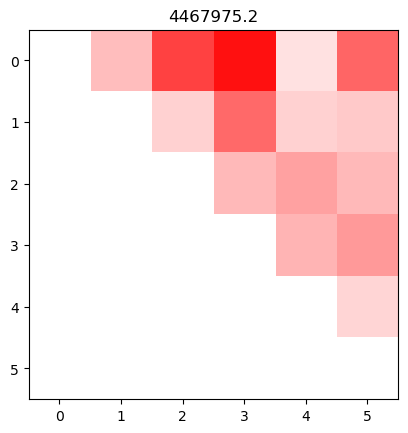

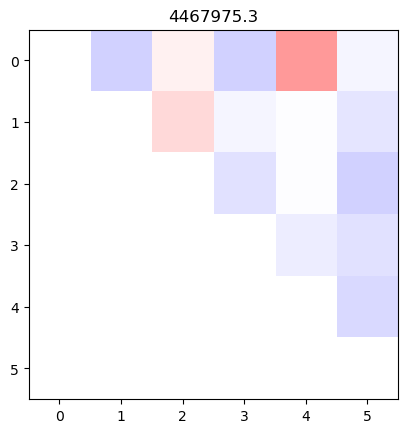

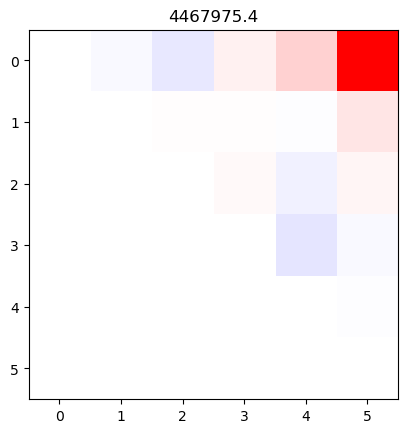

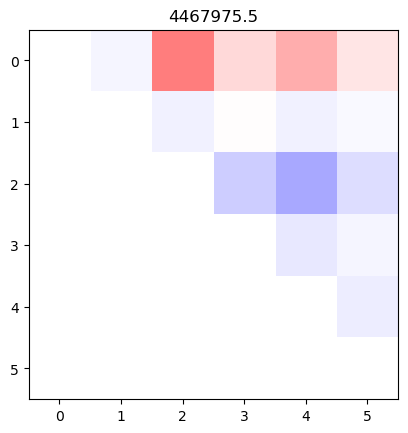

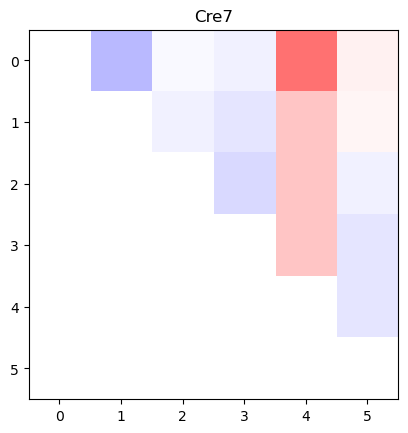

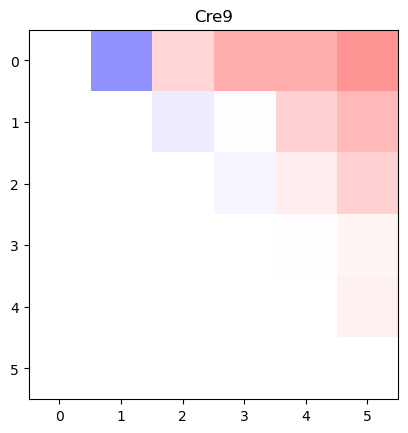

In [9]:
for m, mouse in enumerate(ctrl_mice):
    fig, ax = plt.subplots()
    ax.imshow(ctrl_shift[m,:,:], vmin=-10, vmax=10 , cmap = 'seismic')
    ax.set_title(mouse)
    
for m, mouse in enumerate(ko_mice):
    fig, ax = plt.subplots()
    ax.imshow(ko_shift[m,:,:], vmin=-10, vmax=10 , cmap = 'seismic')
    ax.set_title(mouse)

(9, 6, 6)
-3.3394385435068865 0.004865132948927939
7.0 0.007867132867132868
-4.071622753178825 0.0035753746616274955


/tmp/ipykernel_30624/1671193071.py:11: RuntimeWarning: Mean of empty slice
  t,p = sp.stats.ttest_ind(np.nanmean(np.nanmean(ctrl_shift[:,:,:],axis=-1),axis=-1), np.nanmean(np.nanmean(ko_shift[:,:,:],axis=-1),axis=-1))
/tmp/ipykernel_30624/1671193071.py:13: RuntimeWarning: Mean of empty slice
  t,p = sp.stats.mannwhitneyu(np.nanmean(np.nanmean(ctrl_shift[:,:,:],axis=-1),axis=-1), np.nanmean(np.nanmean(ko_shift[:,:,:],axis=-1),axis=-1))
/tmp/ipykernel_30624/1671193071.py:16: RuntimeWarning: Mean of empty slice
  t,p = sp.stats.ttest_1samp(np.nanmean(np.nanmean(ctrl_shift[:,:,:],axis=-1),axis=-1),0)
/tmp/ipykernel_30624/1671193071.py:20: RuntimeWarning: Mean of empty slice
  mu_ctrl = np.nanmean(np.nanmean(ctrl_shift[:,:,:],axis=-1),axis=-1)
/tmp/ipykernel_30624/1671193071.py:21: RuntimeWarning: Mean of empty slice
  ax.scatter(np.linspace(-.2,-.1, num=len(ctrl_mice)), np.nanmean(np.nanmean(ctrl_shift[:,:,:],axis=-1),axis=-1), color='black')
/tmp/ipykernel_30624/1671193071.py:23: RuntimeW

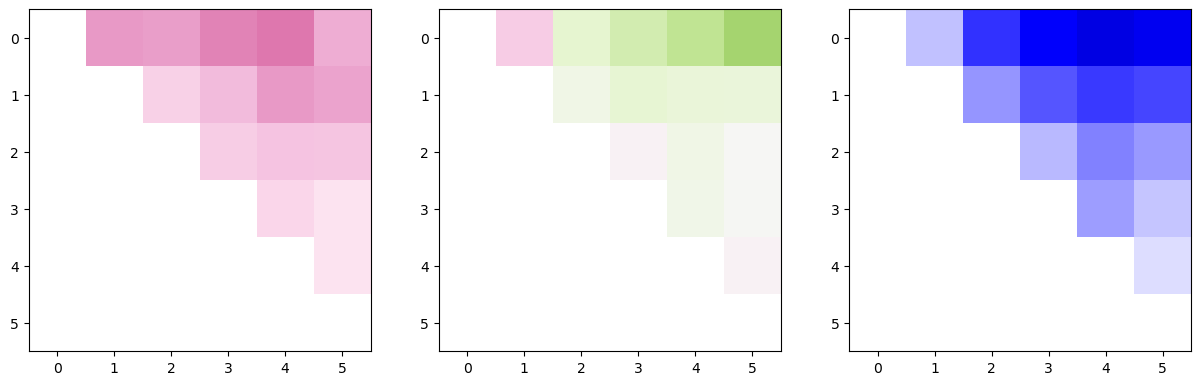

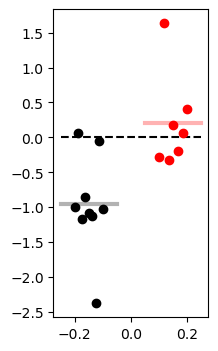

In [11]:
fig, ax = plt.subplots(1,3, figsize=[15,5])
ax[0].imshow(ctrl_shift.mean(axis=0)[:,:], vmin=-3,vmax=3, cmap='PiYG')
ax[1].imshow(ko_shift.mean(axis=0)[:,:], vmin=-3,vmax=3, cmap='PiYG')
ax[2].imshow(ctrl_shift.mean(axis=0)[:,:]-ko_shift.mean(axis=0)[:,:], vmin=-5, vmax=5, cmap='seismic')

# t,p = sp.stats.ttest_ind(ctrl_shift[:,:5,:5], ko_shift[:,:5,:5], axis=0)
# print(t)
# print(p)

print(ctrl_shift.shape)
t,p = sp.stats.ttest_ind(np.nanmean(np.nanmean(ctrl_shift[:,:,:],axis=-1),axis=-1), np.nanmean(np.nanmean(ko_shift[:,:,:],axis=-1),axis=-1))
print(t,p)
t,p = sp.stats.mannwhitneyu(np.nanmean(np.nanmean(ctrl_shift[:,:,:],axis=-1),axis=-1), np.nanmean(np.nanmean(ko_shift[:,:,:],axis=-1),axis=-1))
print(t,p)

t,p = sp.stats.ttest_1samp(np.nanmean(np.nanmean(ctrl_shift[:,:,:],axis=-1),axis=-1),0)
print(t,p)

fig, ax = plt.subplots(figsize=[2,4])
mu_ctrl = np.nanmean(np.nanmean(ctrl_shift[:,:,:],axis=-1),axis=-1)
ax.scatter(np.linspace(-.2,-.1, num=len(ctrl_mice)), np.nanmean(np.nanmean(ctrl_shift[:,:,:],axis=-1),axis=-1), color='black')
ax.plot(np.array([-.25,-.05]), mu_ctrl.mean()*np.ones([2,]),color='black', alpha=.3,linewidth=3)
mu_ko = np.nanmean(np.nanmean(ko_shift[:,:,:],axis=-1),axis=-1)
ax.scatter(np.linspace(.1,.2, num=len(ko_mice)), np.nanmean(np.nanmean(ko_shift[:,:,:],axis=-1),axis=-1), color='red')
ax.plot(np.array([.25,.05]), mu_ko.mean()*np.ones([2,]),color='red', alpha=.3,linewidth=3)
ax.plot([-.25,.25],[0, 0], 'k--', zorder=-1)

In [12]:
ctrl_shift = np.zeros((len(ctrl_mice),6,6))*np.nan
for m, mouse in enumerate(ctrl_mice):
    res = ctrl_multiday_results[mouse]
    for test_day in range(6):
        test_trials = (res['sess_num']==test_day)*(res['fam_trials']>0)
        for train_day in range(6):
            if (train_day >test_day):
                shift = (np.argmax(res['fam_train'][train_day][test_trials,:,:],axis=-1)-np.arange(30)[np.newaxis,:]).mean(axis=-1)
                ctrl_shift[m, test_day,train_day] = np.mean(shift)
            # ax[day].plot(shift, color='black')
        
ko_shift = np.zeros((len(ko_mice),6,6))*np.nan
for m, mouse in enumerate(ko_mice):
    res = ko_multiday_results[mouse]
    for test_day in range(6):
        test_trials = (res['sess_num']==test_day)*(res['fam_trials']>0)
        for train_day in range(6):
            if (train_day > test_day):
                shift = (np.argmax(res['fam_train'][train_day][test_trials,:,:],axis=-1)-np.arange(30)[np.newaxis,:]).mean(axis=-1)
                ko_shift[m, test_day, train_day] = np.mean(shift)

(9, 6, 6)
-2.167022692847341 0.047969968277814044
14.0 0.07115384615384615


/tmp/ipykernel_30624/3158008005.py:11: RuntimeWarning: Mean of empty slice
  t,p = sp.stats.ttest_ind(np.nanmean(np.nanmean(ctrl_shift[:,:,:],axis=-1),axis=-1), np.nanmean(np.nanmean(ko_shift[:,:,:],axis=-1),axis=-1))
/tmp/ipykernel_30624/3158008005.py:13: RuntimeWarning: Mean of empty slice
  t,p = sp.stats.mannwhitneyu(np.nanmean(np.nanmean(ctrl_shift[:,:,:],axis=-1),axis=-1), np.nanmean(np.nanmean(ko_shift[:,:,:],axis=-1),axis=-1))
/tmp/ipykernel_30624/3158008005.py:17: RuntimeWarning: Mean of empty slice
  ax.scatter(np.linspace(-.1,-.05, num=len(ctrl_mice)), np.nanmean(np.nanmean(ctrl_shift[:,:,:],axis=-1),axis=-1), color='black')
/tmp/ipykernel_30624/3158008005.py:18: RuntimeWarning: Mean of empty slice
  ax.scatter(np.linspace(.1,.05, num=len(ko_mice)), np.nanmean(np.nanmean(ko_shift[:,:,:],axis=-1),axis=-1), color='red')


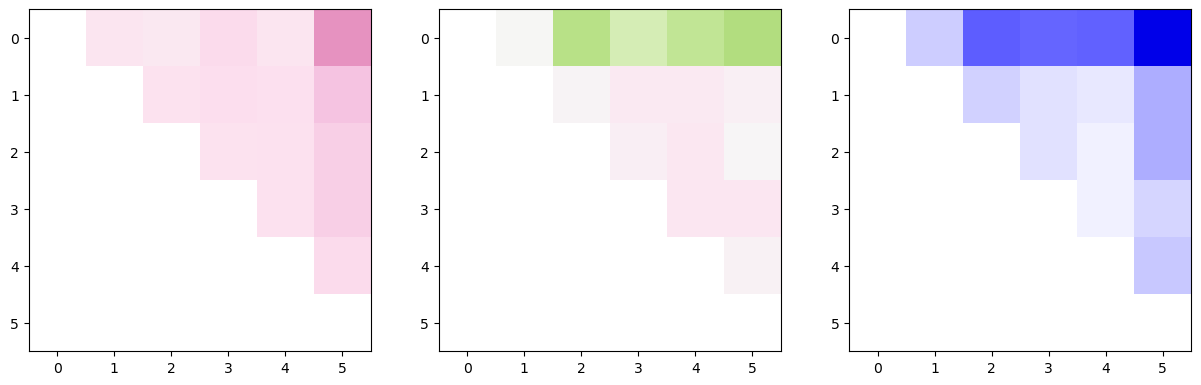

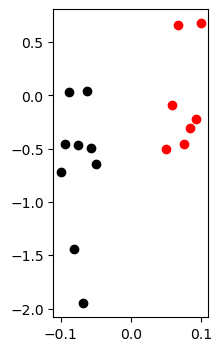

In [13]:
fig, ax = plt.subplots(1,3, figsize=[15,5])
ax[0].imshow(ctrl_shift.mean(axis=0)[:,:], vmin=-3,vmax=3, cmap='PiYG')
ax[1].imshow(ko_shift.mean(axis=0)[:,:], vmin=-3,vmax=3, cmap='PiYG')
ax[2].imshow(ctrl_shift.mean(axis=0)[:,:]-ko_shift.mean(axis=0)[:,:], vmin=-5, vmax=5, cmap='seismic')

# t,p = sp.stats.ttest_ind(ctrl_shift[:,:5,:5], ko_shift[:,:5,:5], axis=0)
# print(t)
# print(p)

print(ctrl_shift.shape)
t,p = sp.stats.ttest_ind(np.nanmean(np.nanmean(ctrl_shift[:,:,:],axis=-1),axis=-1), np.nanmean(np.nanmean(ko_shift[:,:,:],axis=-1),axis=-1))
print(t,p)
t,p = sp.stats.mannwhitneyu(np.nanmean(np.nanmean(ctrl_shift[:,:,:],axis=-1),axis=-1), np.nanmean(np.nanmean(ko_shift[:,:,:],axis=-1),axis=-1))
print(t,p)

fig, ax = plt.subplots(figsize=[2,4])
ax.scatter(np.linspace(-.1,-.05, num=len(ctrl_mice)), np.nanmean(np.nanmean(ctrl_shift[:,:,:],axis=-1),axis=-1), color='black')
ax.scatter(np.linspace(.1,.05, num=len(ko_mice)), np.nanmean(np.nanmean(ko_shift[:,:,:],axis=-1),axis=-1), color='red')

In [14]:
ctrl_nov_err = np.zeros((len(ctrl_mice),6,6))*np.nan
for m, mouse in enumerate(ctrl_mice):
    res = ctrl_multiday_results[mouse]
    for test_day in range(6):
        test_trials = (res['sess_num']==test_day)*(res['novel_trials']>0)
        for train_day in range(6):
            if (train_day != test_day):
                shift = np.abs(np.argmax(res['nov_train'][train_day][test_trials,:,:],axis=-1)-np.arange(30)[np.newaxis,:]).mean(axis=-1)
                ctrl_nov_err[m, test_day,train_day] = np.mean(shift)
            # ax[day].plot(shift, color='black')
        
ko_nov_err = np.zeros((len(ko_mice),6,6))*np.nan
for m, mouse in enumerate(ko_mice):
    res = ko_multiday_results[mouse]
    for test_day in range(6):
        test_trials = (res['sess_num']==test_day)*(res['novel_trials']>0)
        for train_day in range(6):
            if (train_day != test_day):
                shift = np.abs(np.argmax(res['nov_train'][train_day][test_trials,:,:],axis=-1)-np.arange(30)[np.newaxis,:]).mean(axis=-1)
                ko_nov_err[m, test_day, train_day] = np.mean(shift)
            # ax[day].plot(shift, color='red')

-1.320599133251338 0.20781714602155493
20.0 0.2522727272727273


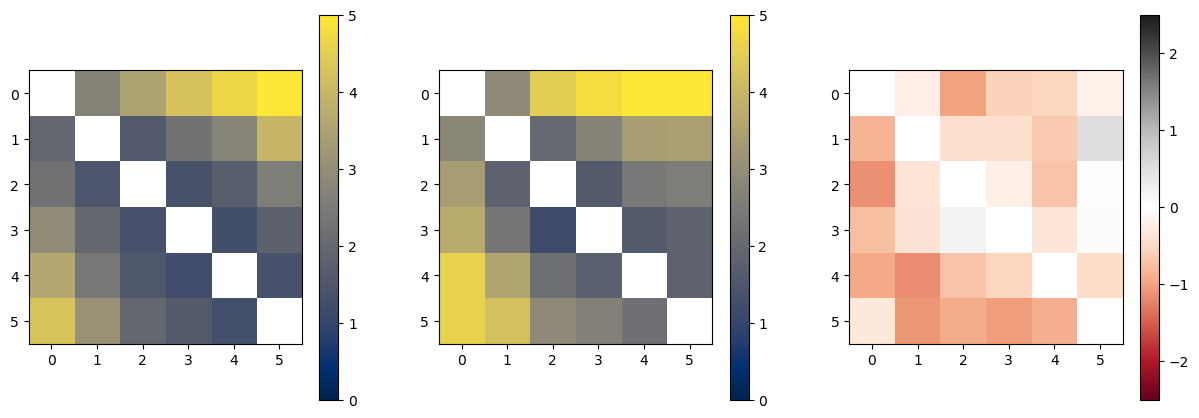

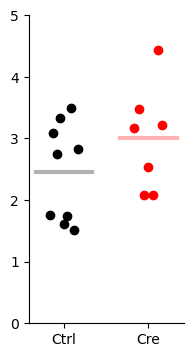

In [15]:
fig, ax = plt.subplots(1,3, figsize=[15,5])
h=ax[0].imshow(ctrl_nov_err.mean(axis=0)[:,:], vmin=0, vmax=5, cmap='cividis')
plt.colorbar(h,ax=ax[0])
h=ax[1].imshow(ko_nov_err.mean(axis=0)[:,:], vmin=0,vmax=5, cmap='cividis')
plt.colorbar(h,ax=ax[1])
h = ax[2].imshow(ctrl_nov_err.mean(axis=0)[:,:]-ko_nov_err.mean(axis=0)[:,:], vmin=-2.5, vmax=2.5, cmap='RdGy')
plt.colorbar(h,ax=ax[2])

fig.savefig(os.path.join(figdir,'nov_across_day_decoding.pdf'),format='pdf')

t,p = sp.stats.ttest_ind(np.nanmean(np.nanmean(ctrl_nov_err[:,:,:],axis=-1),axis=-1), np.nanmean(np.nanmean(ko_nov_err[:,:,:],axis=-1),axis=-1))
print(t,p)
t,p = sp.stats.mannwhitneyu(np.nanmean(np.nanmean(ctrl_nov_err[:,:,:],axis=-1),axis=-1), np.nanmean(np.nanmean(ko_nov_err[:,:,:],axis=-1),axis=-1))
print(t,p)

fig, ax = plt.subplots(figsize=[2,4])
ctrl_mu = np.nanmean(np.nanmean(ctrl_nov_err[:,:,:],axis=-1),axis=-1)
ko_mu = np.nanmean(np.nanmean(ko_nov_err[:,:,:],axis=-1),axis=-1)
ax.scatter(np.linspace(-.2,-.1, num=len(ctrl_mice)), np.nanmean(np.nanmean(ctrl_nov_err[:,:,:],axis=-1),axis=-1), color='black')
ax.scatter(np.linspace(.2,.1, num=len(ko_mice)), np.nanmean(np.nanmean(ko_nov_err[:,:,:],axis=-1),axis=-1), color='red')
ax.set_ylim([0,5])
ax.set_xticks([-.15, .15], labels=['Ctrl', 'Cre'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(np.array([-.25,-.05]), ctrl_mu.mean()*np.ones([2,]),color='black', alpha=.3,linewidth=3)
ax.plot(np.array([.25,.05]), ko_mu.mean()*np.ones([2,]),color='red', alpha=.3,linewidth=3)
fig.savefig(os.path.join(figdir,'nov_across_day_decoding_summary.pdf'),format='pdf')


In [16]:
ctrl_fut_past_diff = []
for m in range(ctrl_nov_err.shape[0]):
    tmp = np.copy(ctrl_nov_err[m,:,:])
    l = tmp[np.tril_indices(6, k=-1)].mean()
    u = tmp[np.triu_indices(6, k=1)].mean()
    # print(l,u)
    # print(ctrl_nov_err[m, 
    # u = np.nanmean(ctrl_nov_err[m,np.triu_indices(6)])
    ctrl_fut_past_diff.append(u-l)

ko_fut_past_diff = []
for m in range(ko_nov_err.shape[0]):
    tmp = np.copy(ko_nov_err[m,:,:])
    l = tmp[np.tril_indices(6, k=-1)].mean()
    u = tmp[np.triu_indices(6, k=1)].mean()
    ko_fut_past_diff.append(u-l)



    

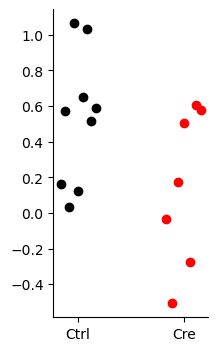

In [17]:
fig, ax = plt.subplots(figsize=[2,4])

ax.scatter(np.linspace(-.2,-.1, num=len(ctrl_mice)), ctrl_fut_past_diff, color='black')
ax.scatter(np.linspace(.2,.1, num=len(ko_mice)), ko_fut_past_diff, color='red')
# ax.set_ylim([0,5])
ax.set_xticks([-.15, .15], labels=['Ctrl', 'Cre'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.plot(np.array([-.25,-.05]), ctrl_mu.mean()*np.ones([2,]),color='black', alpha=.3,linewidth=3)
# ax.plot(np.array([.25,.05]), ko_mu.mean()*np.ones([2,]),color='red', alpha=.3,linewidth=3)

In [18]:
ctrl_fam_err = np.zeros((len(ctrl_mice),6,6))*np.nan
for m, mouse in enumerate(ctrl_mice):
    res = ctrl_multiday_results[mouse]
    for test_day in range(6):
        test_trials = (res['sess_num']==test_day)*(res['fam_trials']>0)
        for train_day in range(6):
            if (train_day != test_day):
                shift = np.abs(np.argmax(res['fam_train'][train_day][test_trials,:,:],axis=-1)-np.arange(30)[np.newaxis,:]).mean(axis=-1)
                ctrl_fam_err[m, test_day,train_day] = np.mean(shift)
            # ax[day].plot(shift, color='black')
        
ko_fam_err = np.zeros((len(ko_mice),6,6))*np.nan
for m, mouse in enumerate(ko_mice):
    res = ko_multiday_results[mouse]
    for test_day in range(6):
        test_trials = (res['sess_num']==test_day)*(res['fam_trials']>0)
        for train_day in range(6):
            if (train_day != test_day):
                shift = np.abs(np.argmax(res['fam_train'][train_day][test_trials,:,:],axis=-1)-np.arange(30)[np.newaxis,:]).mean(axis=-1)
                ko_fam_err[m, test_day, train_day] = np.mean(shift)
            # ax[day].plot(shift, color='red')

-0.9363965597586844 0.364941991291154
23.0 0.4078671328671329


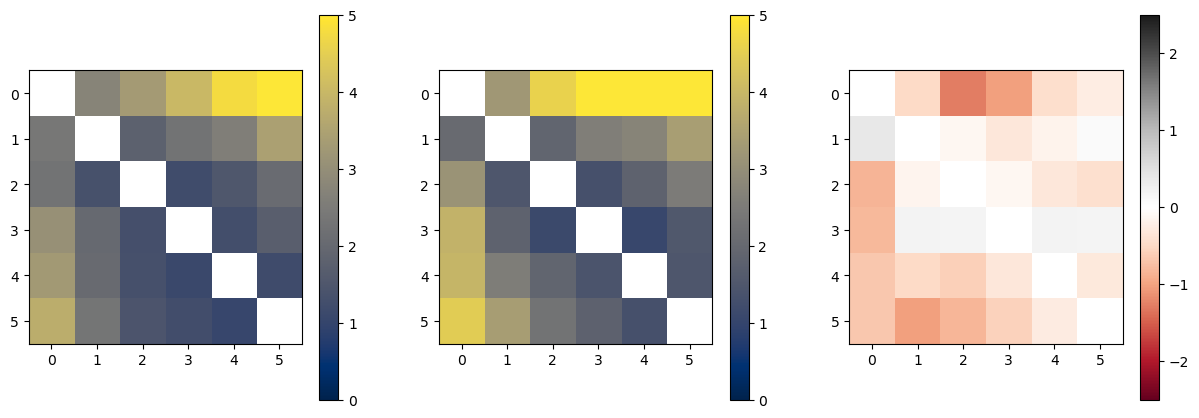

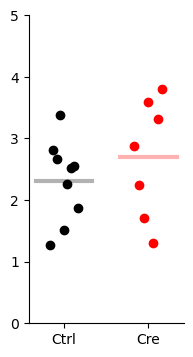

In [19]:
fig, ax = plt.subplots(1,3, figsize=[15,5])
h=ax[0].imshow(ctrl_fam_err.mean(axis=0)[:,:], vmin=0, vmax=5, cmap='cividis')
plt.colorbar(h,ax=ax[0])
h=ax[1].imshow(ko_fam_err.mean(axis=0)[:,:], vmin=0,vmax=5, cmap='cividis')
plt.colorbar(h,ax=ax[1])
h = ax[2].imshow(ctrl_fam_err.mean(axis=0)[:,:]-ko_fam_err.mean(axis=0)[:,:], vmin=-2.5, vmax=2.5, cmap='RdGy')
plt.colorbar(h,ax=ax[2])

fig.savefig(os.path.join(figdir,'fam_across_day_decoding.pdf'),format='pdf')

t,p = sp.stats.ttest_ind(np.nanmean(np.nanmean(ctrl_fam_err[:,:,:],axis=-1),axis=-1), np.nanmean(np.nanmean(ko_fam_err[:,:,:],axis=-1),axis=-1))
print(t,p)
t,p = sp.stats.mannwhitneyu(np.nanmean(np.nanmean(ctrl_fam_err[:,:,:],axis=-1),axis=-1), np.nanmean(np.nanmean(ko_fam_err[:,:,:],axis=-1),axis=-1))
print(t,p)

fig, ax = plt.subplots(figsize=[2,4])
ctrl_mu = np.nanmean(np.nanmean(ctrl_fam_err[:,:,:],axis=-1),axis=-1)
ko_mu = np.nanmean(np.nanmean(ko_fam_err[:,:,:],axis=-1),axis=-1)
ax.scatter(np.linspace(-.2,-.1, num=len(ctrl_mice)), np.nanmean(np.nanmean(ctrl_fam_err[:,:,:],axis=-1),axis=-1), color='black')
ax.scatter(np.linspace(.2,.1, num=len(ko_mice)), np.nanmean(np.nanmean(ko_fam_err[:,:,:],axis=-1),axis=-1), color='red')
ax.set_ylim([0,5])
ax.set_xticks([-.15, .15], labels=['Ctrl', 'Cre'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(np.array([-.25,-.05]), ctrl_mu.mean()*np.ones([2,]),color='black', alpha=.3,linewidth=3)
ax.plot(np.array([.25,.05]), ko_mu.mean()*np.ones([2,]),color='red', alpha=.3,linewidth=3)
fig.savefig(os.path.join(figdir,'fam_across_day_decoding_summary.pdf'),format='pdf')


In [20]:
ctrl_fut_past_diff = []
for m in range(ctrl_fam_err.shape[0]):
    tmp = np.copy(ctrl_fam_err[m,:,:])
    l = tmp[np.tril_indices(6, k=-1)].mean()
    u = tmp[np.triu_indices(6, k=1)].mean()
    # print(l,u)
    # print(ctrl_nov_err[m, 
    # u = np.nanmean(ctrl_nov_err[m,np.triu_indices(6)])
    ctrl_fut_past_diff.append(u-l)

ko_fut_past_diff = []
for m in range(ko_fam_err.shape[0]):
    tmp = np.copy(ko_fam_err[m,:,:])
    l = tmp[np.tril_indices(6, k=-1)].mean()
    u = tmp[np.triu_indices(6, k=1)].mean()
    ko_fut_past_diff.append(u-l)



    

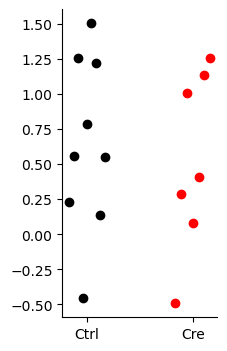

In [21]:
fig, ax = plt.subplots(figsize=[2,4])

ax.scatter(np.linspace(-.2,-.1, num=len(ctrl_mice)), ctrl_fut_past_diff, color='black')
ax.scatter(np.linspace(.2,.1, num=len(ko_mice)), ko_fut_past_diff, color='red')
# ax.set_ylim([0,5])
ax.set_xticks([-.15, .15], labels=['Ctrl', 'Cre'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

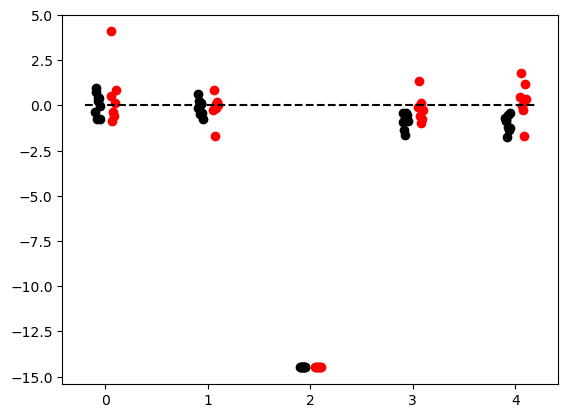

In [186]:
fig,ax = plt.subplots()
for day in range(5):
    ax.scatter(np.linspace(-.1,-.05,num=len(ctrl_mice))+day, ctrl_shift[:,day], color='black')
    ax.scatter(np.linspace(.05,.1,num=len(ko_mice))+day, ko_shift[:,day], color='red')
    
ax.plot(np.linspace(-.2,4.2,num=20),np.zeros((20,)), color='black', linestyle='dashed')

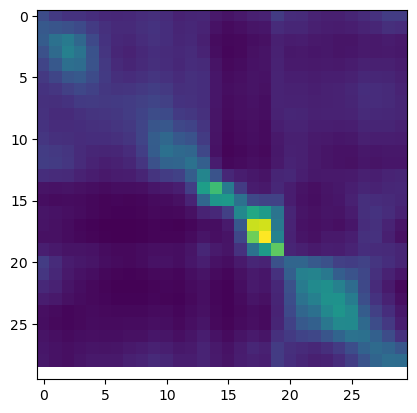

In [132]:
fig, ax = plt.subplots()
ax.imshow(res['fam_train'][1][test_trials,:,:].mean(axis=0))